In [34]:
import pandas as pd
from os.path import basename
from ugvc.reports import report_utils
from ugvc.reports.report_utils import ReportUtils
from ugvc.reports.report_data_loader import ReportDataLoader
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [ ]:
run_id = "NA"
pipeline_version = "NA"
statistics_file = "cnv.stats.pkl"
reference_version = "hg38"
truth_sample_name = "NA"
h5outfile = "var_report.h5"    


In [41]:
parameters = {
    'statistics_file': statistics_file,
    'run_id': run_id,
    'reference_version': reference_version,
    'pipeline_version': str(pipeline_version),
    'truth_sample_name': truth_sample_name,
    'h5outfile': h5outfile,
}

parameters = {name: parameters[name] for name in parameters if parameters[name] is not None}
param_names = list(parameters)

report_utils = ReportUtils(1, h5outfile)

display(Markdown(f"# SV/CNV Calling report {pipeline_version} (INTERNAL usage)"))


# SV/CNV Calling report NA (INTERNAL usage)

## 1. Input Parameters <a class="anchor" id="input_parameters"></a>

In [42]:
# load data
data_loader = ReportDataLoader(concordance_file=parameters['statistics_file'],
                               reference_version=parameters['reference_version'],
                               exome_column_name = "exome.twist"
)
data_no_gt, data_gt = data_loader.load_sv_concordance_df()
has_concordance_data = len(data_gt)>0

In [43]:
parameters_df = pd.DataFrame.from_dict(parameters, orient='index', columns=['value']).reindex(param_names)
parameters_df.loc['statistics_file', 'value'] = basename(str(parameters_df.loc['statistics_file', 'value']))
parameters_df.to_hdf(h5outfile, key="parameters")
display(parameters_df)

,value
statistics_file,NA24149_vs_NA24385.stats.pkl
run_id,NA
reference_version,hg38
pipeline_version,NA
truth_sample_name,NA
h5outfile,var_report.h5


In [44]:
anchor = report_utils.get_anchor("top")
display(Markdown(f"## Table of Contents {anchor}"))
tc = "* [Input Parameters](#input_parameters)\n"
tc += "* [General statistics](#general_statistics)\n"
if has_concordance_data:
    tc += "* [Accuracy](#concordance_eval)\n"

display(Markdown(tc))

## Table of Contents <a class ='anchor' id='top'> </a>

* [Input Parameters](#input_parameters)
* [General statistics](#general_statistics)
* [Accuracy](#concordance_eval)


## General statistics  <a class='anchor' id='general_statistics'></a>

The tables below summarize class and length distributions of called SVs


### SV type distribution

In [45]:
pd.options.display.float_format = '{:,.2%}'.format
data_no_gt['type_counts'].name = 'SV type'
data_no_gt['type_counts'] = pd.DataFrame(data_no_gt['type_counts']).T

In [46]:
data_no_gt['type_counts'].to_hdf(h5outfile, key="type_counts")

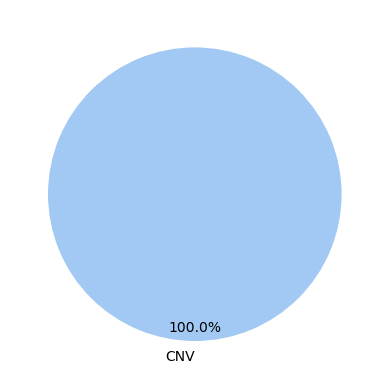

In [47]:
# Pie chart of data_no_gt['type_counts']
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data_no_gt['type_counts'].values[0],
                                   labels=data_no_gt['type_counts'].columns,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   colors=sns.color_palette("pastel"),
                                    pctdistance=0.9,         # keep percentages inside
                                    labeldistance=1.1,        # move labels outside

                                   textprops=dict(color="b"))
for text in texts + autotexts:
    text.set_color("black")
    text.set_fontsize(10)

### SV length distribution

In [48]:
data_no_gt['length_counts'].name = 'SV Length'
data_no_gt['length_counts'] = pd.DataFrame(data_no_gt['length_counts']).T
data_no_gt['length_counts']

,50-100,100-300,300-500,0.5-1k,1k-2k,2k-3k,3k-5k,5k-10k,10k-100k,100k-1M,>1M
SV Length,0,0,0,0,0,0,0,0,139,12,0


In [49]:
data_no_gt['length_counts'].columns = data_no_gt['length_counts'].columns.astype(str)
data_no_gt['length_counts'].to_hdf(h5outfile, key="length_counts")

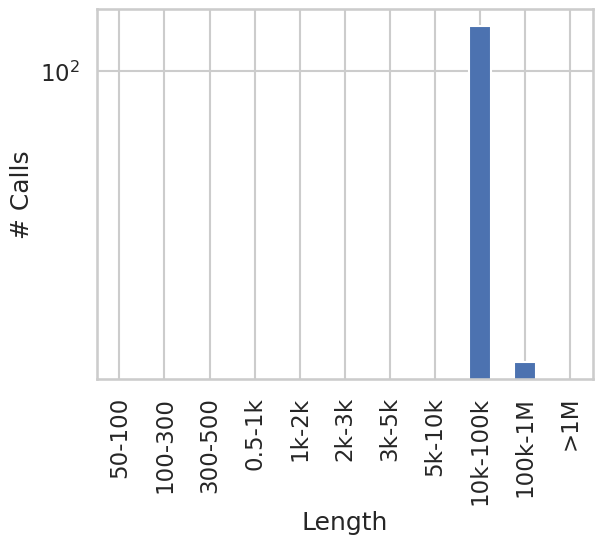

In [50]:
data_no_gt['length_counts'].T.plot.bar(legend=False)
plt.xlabel("Length")
plt.ylabel('# Calls')
# set y axis log scale
plt.yscale('log')


### Length and type distribution

In [51]:
data_no_gt['length_by_type_counts']

binned_svlens,50-100,100-300,300-500,0.5-1k,1k-2k,2k-3k,3k-5k,5k-10k,10k-100k,100k-1M,>1M
svtype,,,,,,,,,,,
CNV,0,0,0,0,0,0,0,0,139,12,0


In [52]:
data_no_gt['length_by_type_counts'] = data_no_gt['length_by_type_counts'].T

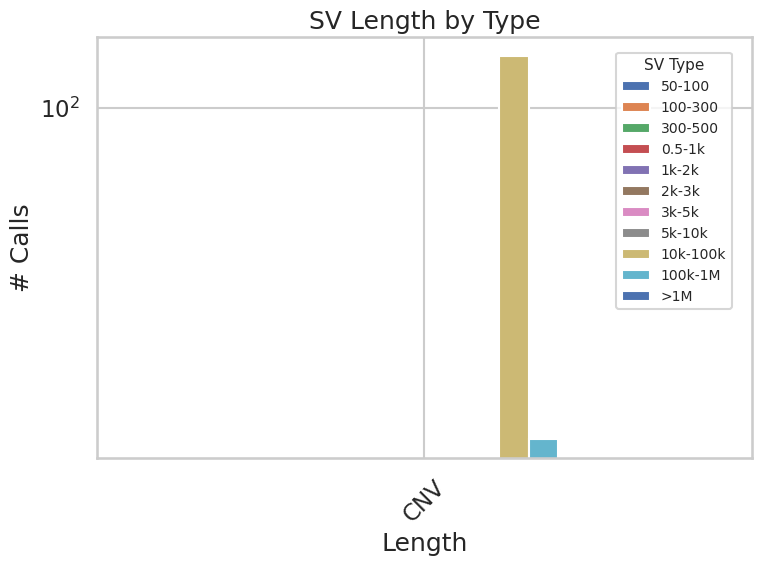

In [53]:
# Make sure the SV types are in the desired order
desired_order = ['CNV', 'DEL', 'INS', 'DUP', 'BND']
df = data_no_gt['length_by_type_counts']
df = df.set_index('svtype') if 'svtype' in df.columns else df
df = df.reindex(desired_order,axis=1).dropna(how='all',axis=1)

# Plot with legend inside and correct order
ax = df.T.plot(kind='bar', stacked=False, figsize=(8, 6))
plt.xlabel("Length")
plt.ylabel('# Calls')
plt.title('SV Length by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(
    title='SV Type',
    loc='upper right',   # inside the plot
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10,
    title_fontsize=11
)
plt.yscale('log')
plt.show()


In [54]:
data_no_gt['length_by_type_counts'].to_hdf(h5outfile, key="length_by_type_counts")

In [55]:
if has_concordance_data:
    anchor = report_utils.get_anchor('concordance_eval')
    display(Markdown(f"## Concordance evaluation {anchor}"))


## Concordance evaluation <a class ='anchor' id='concordance_eval'> </a>

In [56]:
if has_concordance_data:
    display(Markdown(f"### Overall concordance"))
    concordance_df = data_gt['concordance'].copy()


### Overall concordance

In [57]:
if has_concordance_data:
    display(Markdown("Recall and precision with comparison to ground truth. Note that the categories of the variants in ground truth may be different from the callset. "
                     "In the evaluation we do not compare the variant type in the callset to that of the truth set."))
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`==""').droplevel(1,axis=0)
    values_df = values_df[['TP_base', 'TP_calls', 'FP', 'FN','Recall','Precision','F1']]
    roc_df    = concordance_df.query('`SV length`==""').droplevel(1,axis=0)[['precision roc', 'recall roc','thresholds']]
    # show pandas representation for TP_base, TP_calls, FP and FN as integers
    values_df[['TP_base', 'TP_calls', 'FP', 'FN']] = values_df[['TP_base', 'TP_calls', 'FP', 'FN']].astype(int)
    values_df = values_df.loc[values_df['TP_base'] > 0] # remove cases absent from ground truth
    roc_df = roc_df.loc[values_df.index]
    display(values_df)
    values_df.to_hdf(h5outfile, key="recall_per_type")

Recall and precision with comparison to ground truth. Note that the categories of the variants in ground truth may be different from the callset. In the evaluation we do not compare the variant type in the callset to that of the truth set.

,TP_base,TP_calls,FP,FN,Recall,Precision,F1
SV type,,,,,,,
ALL,34,34,14,12,73.91%,70.83%,72.34%


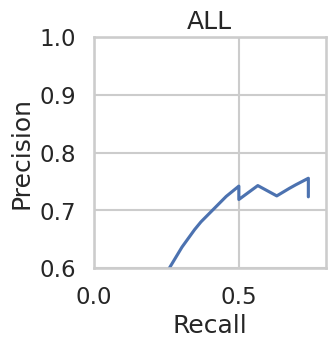

In [58]:
if has_concordance_data:
    if max([len(x) for x in roc_df[:].values[0]]) > 0:
        fig,ax = plt.subplots(1,roc_df.shape[0],figsize=(roc_df.shape[0]*3,3))
        if roc_df.shape[0]==1:
            ax=[ax]
        for i,v in enumerate(roc_df.iterrows()):
            plt.subplot(1,roc_df.shape[0],i+1)
            plt.plot(v[1]['recall roc'],v[1]['precision roc'])
            plt.title(v[0])
            plt.xlabel('Recall')
            plt.xlim(0,0.8)
            plt.ylim(0.6,1)
        ax[0].set_ylabel("Precision")


In [59]:
if has_concordance_data:
    display(Markdown(f"### Recall per variant length and type"))
    concordance_df = data_gt['concordance'].copy()
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`!=""')
    values_df = values_df[['TP_base', 'TP_calls', 'FN','Recall']]
    values_df[['TP_base','TP_calls','FN']] = values_df[['TP_base','TP_calls','FN']].astype(int)
    display(values_df)
    values_df.index = values_df.index.rename({'SV length':'SV_length', 'SV type':'SV_type'})
    values_df.to_hdf(h5outfile, key="recall_per_length_and_type")


### Recall per variant length and type

TP_base  TP_calls  FN  Recall
SV type SV length                               
ALL     50-100           0         0   0   0.00%
        100-300          0         0   0   0.00%
        300-500          0         0   0   0.00%
        0.5-1k           0         0   0   0.00%
        1k-2k            0         0   0   0.00%
        2k-3k            0         0   0   0.00%
        3k-5k            0         0   0   0.00%
        5k-10k           0         0   0   0.00%
        10k-100k        34        34  12  73.91%
        100k-1M          0         0   0   0.00%
        >1M              0         0   0   0.00%
DEL     50-100           0         0   0   0.00%
        100-300          0         0   0   0.00%
        300-500          0         0   0   0.00%
        0.5-1k           0         0   0   0.00%
        1k-2k            0         0   0   0.00%
        2k-3k            0         0   0   0.00%
        3k-5k            0         0   0   0.00%
        5k-10k           0         0   0   0.00%
        10k-100k         0         0   0   0.00%
        100k-1M          0         0   0   0.00%
        >1M              0         0   0   0.00%
INS     50-100           0         0   0   0.00%
        100-300          0         0   0   0.00%
        300-500          0         0   0   0.00%
        0.5-1k           0         0   0   0.00%
        1k-2k            0         0   0   0.00%
        2k-3k            0         0   0   0.00%
        3k-5k            0         0   0   0.00%
        5k-10k           0         0   0   0.00%
        10k-100k         0         0   0   0.00%
        100k-1M          0         0   0   0.00%
        >1M              0         0   0   0.00%

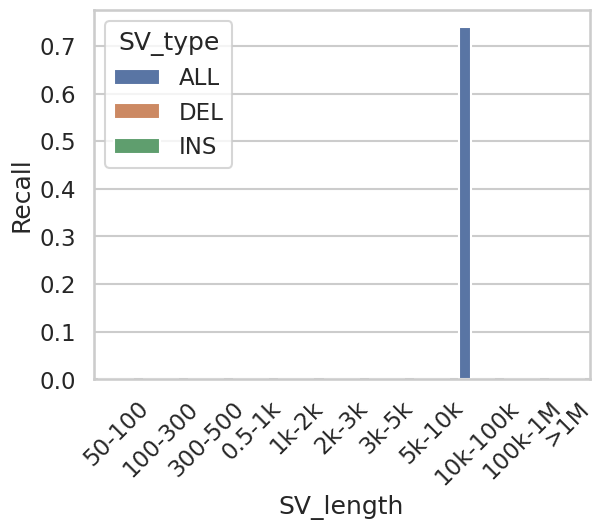

In [60]:
if has_concordance_data:
    sns.barplot(data=values_df.reset_index(), x='SV_length', y='Recall', hue='SV_type')
    plt.xticks(rotation=45);

### False positives per variant length and type

SV type,10k-100k
SV length,
CNV,14


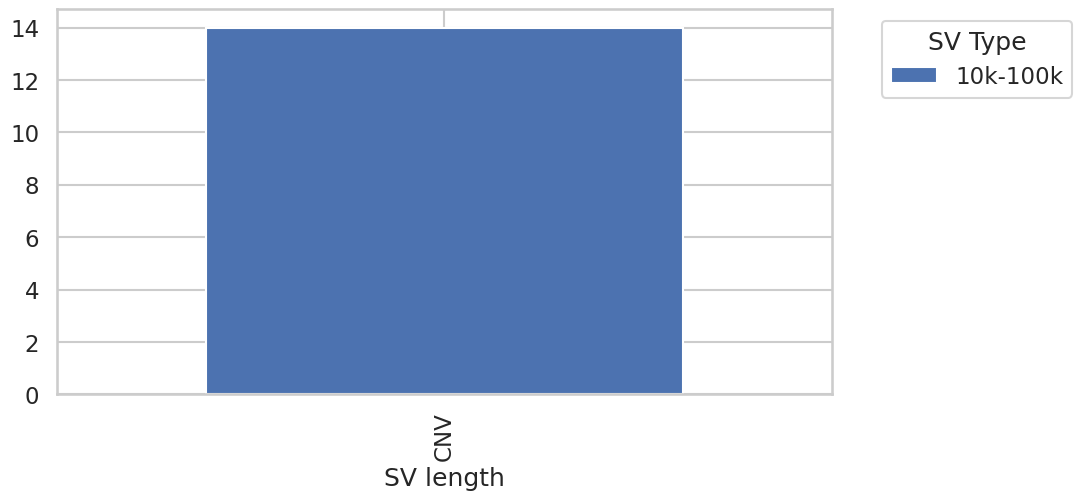

In [61]:
if has_concordance_data:
    display(Markdown(f"### False positives per variant length and type"))
    fp_df = data_gt['fp_stats'].copy()
    # Convert the series fp_df to dataframe by making the first level of index columns
    fp_df = fp_df.reset_index()
    fp_df.columns = ['SV length', 'SV type', 'FP count']
    fp_df = fp_df.pivot(index='SV length', columns='SV type', values='FP count').fillna(0).astype(int)
    display(fp_df)
    fp_df.plot.bar(figsize=(10, 5), width=0.8)
    #place legend outside
    plt.legend(title='SV Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    fp_df.columns = fp_df.columns.astype(str)
    fp_df.to_hdf(h5outfile, key="fp_counts_per_length_and_type")